# Thumbnail Search

In [42]:
# Imports
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

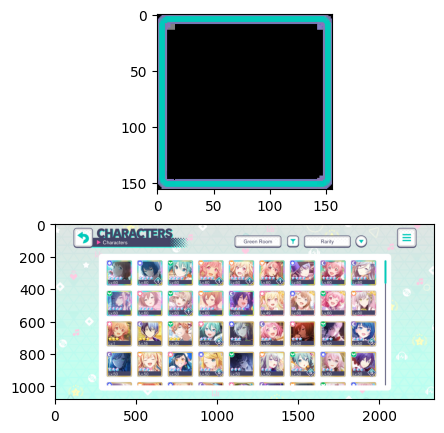

In [43]:
# Load images in BGR format
img_frame = cv.imread('../img/frame_1_blank.png')
img_list = cv.imread('../img/character-list.jpg')

_, plots = plt.subplots(2, 1, figsize=(10, 5))
plots[0].imshow(img_frame[...,::-1])
plots[1].imshow(img_list[...,::-1])

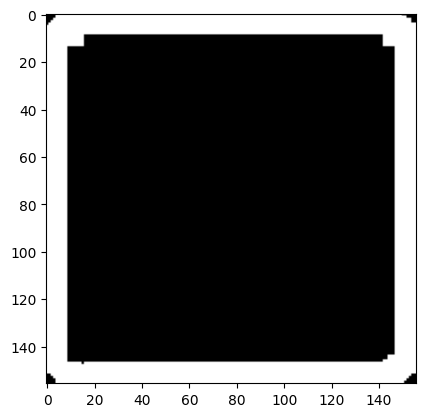

In [44]:
# Frame has a blank background which gets loaded in as black, so just threshold against this
img_frame_gray = cv.cvtColor(img_frame, cv.COLOR_BGR2GRAY)
_, img_frame_thresholded = cv.threshold(img_frame_gray, 0, 255, cv.THRESH_BINARY)
plt.imshow(img_frame_thresholded, cmap='gray')

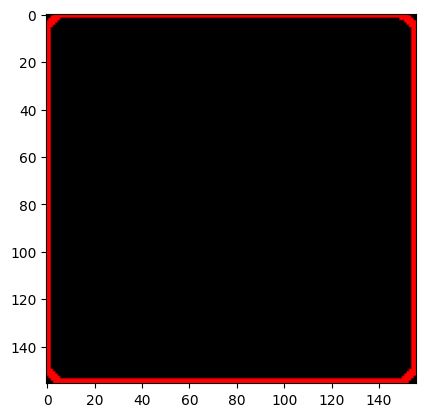

In [45]:
# Find contours in the frame, so we can use them later
img_frame_contours = np.zeros(img_frame.shape, dtype='B')
contours_frame, _ = cv.findContours(img_frame_thresholded.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_frame_contours, contours_frame, 0, (0, 0, 255), 2)

plt.imshow(img_frame_contours[..., ::-1])

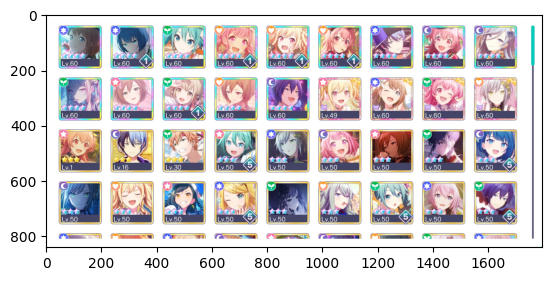

In [46]:
# Find the character box in the image
# This can be done by searching for the largest external contour
img_list_gray = cv.cvtColor(img_list, cv.COLOR_BGR2GRAY)
_, img_list_thresholded = cv.threshold(img_list_gray, 250, 255, cv.THRESH_BINARY)
contours_list, _ = cv.findContours(img_list_thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

contour_areas = [cv.contourArea(contour) for contour in contours_list]
contour_max_index = np.argmax(contour_areas)
max_contour = contours_list[contour_max_index]
max_contour_approx = cv.approxPolyDP(max_contour, 0.1 * cv.arcLength(max_contour, True), True)

x, y, w, h = cv.boundingRect(max_contour_approx)

img_box = img_list[y:y+h, x:x+w]
plt.imshow(img_box[..., ::-1])

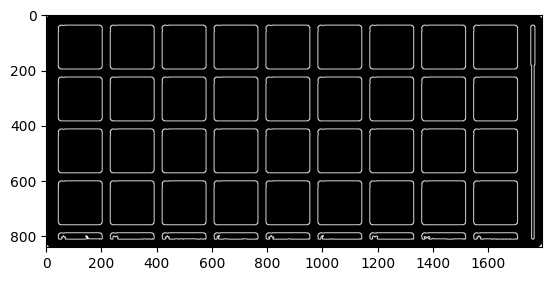

In [47]:
# Find contours within the character box
img_box_gray = img_list_gray[y:y+h, x:x+w]
img_box_gray_blurred = cv.GaussianBlur(img_box_gray, (5, 5), 0)
_, img_box_thresholded = cv.threshold(img_box_gray_blurred, 250, 255, cv.THRESH_BINARY_INV)
# plt.imshow(img_box_thresholded, cmap='gray')

# RETR_EXTERNAL seems to be the best option - it only finds the outer contours
img_box_contours = np.zeros(img_box_gray.shape, dtype='B')
contours_box, _ = cv.findContours(img_box_thresholded, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cv.drawContours(img_box_contours, contours_box, -1, 255, 2)

plt.imshow(img_box_contours, cmap='gray')

[3.1000414283455755, 3.229491282396394, 2.9281192225112522, 2.915005395021607, 2.9821981604976284, 2.98995492135994, 3.2379182440712593, 2.9580606716817184, 3.235327750716976, 2.473198420438896]
10
2.473198420438896
3.004931549704125
3.2379182440712593
[160, 160, 160, 160, 160, 160, 160, 160, 160, 16]
16
145.6
160
145.6
160 24
160 24
160 24
160 24
160 24
160 24
160 24
160 24
160 24
16 776


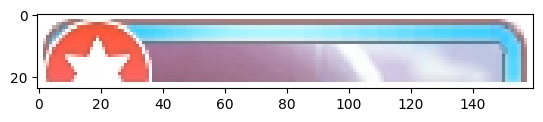

In [48]:
# Search for the frame's contour in the character box
# Should be viable now that the other 'rounded squares' are no longer present
# Based on the output from matchShapes, it looks like anything > 4 is probably a match
ret_values = []
card_bounding_boxes = []

for contour_box in contours_box:
    # NOTE: This assumes that the first contour in the frame is the largest one
    ret = cv.matchShapes(contours_frame[0], contour_box, cv.CONTOURS_MATCH_I1, 0.0)
    
    if (ret > 1):
        ret_values.append(ret)

        card_bounding_box = cv.boundingRect(contour_box)
        card_bounding_boxes.append(card_bounding_box)

print(ret_values)
print(len(ret_values))

print(np.min(ret_values))
print(np.average(ret_values))
print(np.max(ret_values))

# A lot of the matched shapes are too small
# So only consider ones with the right width
box_widths = [wb for (_, _, wb, _) in card_bounding_boxes]

print(box_widths)
print(np.min(box_widths))
print(np.average(box_widths))
print(np.max(box_widths))

card_bounding_boxes = np.array(card_bounding_boxes)
box_width_avg = np.average(card_bounding_boxes[:,2])
print(box_width_avg)

for (xb, yb, wb, hb) in card_bounding_boxes:
    print(wb, hb)

    if wb < box_width_avg:
        continue

    card_thumbnail = img_box[yb:yb+hb, xb:xb+wb]
    plt.imshow(card_thumbnail)